# Preamble

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
import pickle

from multiprocessing import Pool 
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm as tqdm


import integrals as integ
import diff_eq_multi_2 as diff_eq
import physics as phys

# Load the standard solution.
a = pickle.load(open('../data/std_soln_He.p','rb'))

std_Tm = interp1d(a[0,:], a[1,:])
std_xH = interp1d(a[0,:], a[2,:])

# Constraints on $Q_\text{eff}$

In [4]:
def max_Q_d_eff(m_m, m_C, f, Q):
    '''
    Constraints on Q_eff from self-interaction, CMB and tight coupling. Q_eff 
    is defined by Q_eff^4 = alpha_C*alpha_m / alpha_EM^2
    '''
    g_em    = np.sqrt(4*np.pi*phys.alpha)
    mu_pC   = m_C*phys.mp/(m_C + phys.mp)
    f_ratio = 1. + phys.omega_baryon/(f*phys.omega_DM)
    
    max_SI             = 0.26*(m_C/1e9)**(3/8) * np.sqrt(np.sqrt(4*np.pi)/g_em)
    max_CMB            = 1e-3 * np.sqrt(m_C/1e9) * np.sqrt(m_m/1e9) * (1e9/(m_m + m_C))**0.25 * f_ratio**0.25
    max_tight_coupling = 0.08 * np.sqrt(Q) * np.sqrt(m_C/1e8) * (1e9/m_m)**0.25
    
    return np.min((max_SI, max_CMB, max_tight_coupling))

# Function for Solving ODE

In [5]:
 def solve_ODE(params):
    '''
    Sets up the ODE with parameters given in params. 
    '''
        
    _m_m      = params[0]
    _m_C      = params[1]
    _f        = params[2]
    _Q        = params[3]
    _rtol     = params[4]
    _max_step = params[5]
    init_cond = params[6]
    
    # Fine the maximum Q_d,eff from the input parameters. 
    _Q_d_eff = max_Q_d_eff(_m_m, _m_C, _f, _Q)

    def to_integrate(rs, var):

        # Decide whether to include neutrals.
        neutral_H  = True
        neutral_He = True

        # Gets the function that returns all the derivatives. 
        # Last option here is whether to integrate with log_T_C or not.
        return diff_eq.DM_baryon_ODE(
            rs, var,
            _m_m, _m_C, _Q, _Q_d_eff, neutral_H, neutral_He, _f, True
        )

    # Number of attempts before giving up. 
    N_attempts = 0
    # Flag to determine if solution was reached.
    solved     = False

    # List of indices (m_m, Q) where the solution failed. 
    error_arr = [] 

    while (not solved) and (N_attempts < 1):
        # Keep attempting until solved or we've tried twice. 

        try:

            N_attempts += 1

            # Solve using solve_ivp. 
            soln = solve_ivp(
                to_integrate, [rs_vec[0], rs_vec[-1]], init_cond, 
                method='BDF', t_eval=rs_vec, 
                rtol=_rtol, max_step=_max_step
            )

        except:
            # solve_ivp returned an error. Adjust the tolerance
            # and step size and try again. 

            _rtol /= 1.2
            _max_step /= 1.5

        else:
            # solve_ivp completed successfully. However, we still need to check
            # that the solution managed to integrate over the entire redshift range,
            # and that there are no NaNs in the solution.
            if soln['t'].size == rs_vec.size and not np.isnan(soln['y']).any():

                solved = True

    if not solved:
        # If solution fails, simply return False. 
        soln = False

    return soln 

# Fixed Parameters

In [6]:
rs_start = 4000
rs_vec   = np.flipud(np.arange(10., rs_start, 1))

# Fixed Parameters
f   = 1e-4
m_C = 1e8   

# Loop Points
# m_m_arr = np.array([3e6, 1e7, 3e7, 1e8, 3e8, 1e9, 3e9, 1e10, 3e10, 1e11, 3e11, 1e12, 3e12, 1e13])
m_m       = 3e8
Q_arr     = 10**np.arange(-6.,  0.2, 0.2) # 31 entries
V_rel_arr = np.arange(0., 4.1, 0.103) * 29e5 / phys.c
V_rel_arr[0] = 1e-16
# Q_arr = Q_arr[::3]
# V_rel_arr = V_rel_arr[::10]

In [7]:
print(V_rel_arr * phys.c / 29e5)

[1.0337671e-12 1.0300000e-01 2.0600000e-01 3.0900000e-01 4.1200000e-01
 5.1500000e-01 6.1800000e-01 7.2100000e-01 8.2400000e-01 9.2700000e-01
 1.0300000e+00 1.1330000e+00 1.2360000e+00 1.3390000e+00 1.4420000e+00
 1.5450000e+00 1.6480000e+00 1.7510000e+00 1.8540000e+00 1.9570000e+00
 2.0600000e+00 2.1630000e+00 2.2660000e+00 2.3690000e+00 2.4720000e+00
 2.5750000e+00 2.6780000e+00 2.7810000e+00 2.8840000e+00 2.9870000e+00
 3.0900000e+00 3.1930000e+00 3.2960000e+00 3.3990000e+00 3.5020000e+00
 3.6050000e+00 3.7080000e+00 3.8110000e+00 3.9140000e+00 4.0170000e+00]


# Loop

In [8]:
import warnings
warnings.simplefilter('ignore')

soln_arr = np.zeros((Q_arr.size, V_rel_arr.size, rs_vec.size, 6))

error_arr = []

for i,Q in enumerate(tqdm(Q_arr)):
    
     # Initial conditions are T_CMB - T_b, T_b - T_m, log(T_C), log(V_bm), log(V_cb), xe
#     init_cond = [1e-5, 1e-5, np.log(1e-6), np.log(1e-16), np.log(1e-16), 1.] 
    init_cond = np.array([[1e-5, 1e-5, np.log(1e-6), np.log(1e-16), np.log(V_rel), 1.] for V_rel in V_rel_arr])
    
    # List of parameters that need to be passed. 
    params = zip(
        m_m*np.ones_like(V_rel_arr) , m_C*np.ones_like(V_rel_arr),
        f*np.ones_like(V_rel_arr)   , Q*np.ones_like(V_rel_arr),
        1e-4*np.ones_like(V_rel_arr), np.inf*np.ones_like(V_rel_arr),
        init_cond
    )
    
    
    # Parallelization.
    pool = Pool(V_rel_arr.size)
    
    soln_raw_arr = list(tqdm(pool.imap(solve_ODE, params)))
    
    for j,soln_raw in enumerate(soln_raw_arr): 
    
        if soln_raw:

            soln = np.transpose(soln_raw['y'])
            
            soln_arr[i,j] = soln

            # Convert to (T_b, T_m, T_C, V_bm, V_mC)
            soln_arr[i,j,:,0] = phys.TCMB(rs_vec) - soln_arr[i,j,:,0]
            soln_arr[i,j,:,1] = soln_arr[i,j,:,0] - soln_arr[i,j,:,1]
            soln_arr[i,j,:,2] = np.exp(soln_arr[i,j,:,2])
            soln_arr[i,j,:,3] = np.exp(soln_arr[i,j,:,3])
            soln_arr[i,j,:,4] = np.exp(soln_arr[i,j,:,4])

        else:
        
            # False was returned, and the solution failed. Append the index
            # to error_arr.
            error_arr.append([i,j])
            
    print('Errors: ', error_arr)
        



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28], [22, 0], [22, 10], [22, 26]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28], [22, 0], [22, 10], [22, 26], [23, 9], [23, 14], [23, 17], [23, 18], [23, 23], [23, 24], [23, 32]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28], [22, 0], [22, 10], [22, 26], [23, 9], [23, 14], [23, 17], [23, 18], [23, 23], [23, 24], [23, 32], [24, 27]]



Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28], [22, 0], [22, 10], [22, 26], [23, 9], [23, 14], [23, 17], [23, 18], [23, 23], [23, 24], [23, 32], [24, 27], [25, 0], [25, 1


Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28], [22, 0], [22, 10], [22, 26], [23, 9], [23, 14], [23, 17], [23, 18], [23, 23], [23, 24], [23, 32], [24, 27], [25, 0], [25, 1


Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28], [22, 0], [22, 10], [22, 26], [23, 9], [23, 14], [23, 17], [23, 18], [23, 23], [23, 24], [23, 32], [24, 27], [25, 0], [25, 1


Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28], [22, 0], [22, 10], [22, 26], [23, 9], [23, 14], [23, 17], [23, 18], [23, 23], [23, 24], [23, 32], [24, 27], [25, 0], [25, 1


Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28], [22, 0], [22, 10], [22, 26], [23, 9], [23, 14], [23, 17], [23, 18], [23, 23], [23, 24], [23, 32], [24, 27], [25, 0], [25, 1


Errors:  [[0, 0], [0, 5], [0, 22], [0, 26], [1, 0], [1, 3], [1, 9], [1, 13], [1, 17], [1, 18], [1, 21], [1, 23], [1, 24], [1, 27], [1, 30], [1, 33], [1, 34], [2, 0], [3, 0], [3, 2], [3, 18], [3, 29], [3, 35], [4, 0], [4, 2], [4, 10], [4, 13], [4, 18], [4, 19], [4, 25], [4, 28], [5, 0], [5, 2], [5, 3], [5, 21], [5, 33], [5, 35], [6, 0], [6, 14], [6, 34], [7, 0], [7, 18], [7, 26], [8, 0], [8, 5], [8, 12], [8, 19], [8, 39], [9, 0], [9, 9], [9, 36], [10, 0], [10, 1], [10, 9], [11, 9], [11, 24], [11, 32], [12, 0], [12, 9], [13, 0], [13, 8], [13, 12], [14, 0], [14, 27], [15, 0], [15, 3], [15, 15], [15, 37], [16, 0], [16, 2], [16, 17], [16, 27], [17, 0], [17, 16], [17, 29], [17, 33], [17, 35], [18, 0], [18, 2], [18, 4], [18, 9], [18, 13], [18, 19], [18, 20], [18, 33], [18, 35], [19, 0], [19, 2], [19, 3], [19, 5], [19, 6], [19, 13], [20, 18], [20, 26], [21, 0], [21, 28], [22, 0], [22, 10], [22, 26], [23, 9], [23, 14], [23, 17], [23, 18], [23, 23], [23, 24], [23, 32], [24, 27], [25, 0], [25, 1

In [11]:
# pickle.dump((soln_arr, error_arr), open('/tigress/hongwanl/millicharged_DM_with_bath/data_Vrel_m_m_3e8.p','wb'))

soln_arr, error_arr = pickle.load(open('/tigress/hongwanl/millicharged_DM_with_bath/data_Vrel_m_m_3e8.p','rb'))


# Handling Problematic Points

In [31]:
import warnings
warnings.simplefilter('ignore')


print('Number of problematic points: ', len(error_arr))

# Pull the list of Q and V_rel that need to be iterated over from error_arr.
Q_err_arr     = np.array([Q_arr[pt[0]] for pt in error_arr])
V_rel_err_arr = np.array([V_rel_arr[pt[1]] for pt in error_arr])


# Keeps track of which points become solved after running this cell.
solved_arr  = [False for _ in error_arr]

# Strategies: adjust step-size, initial conditions

# New set of parameters for solution, pulled from the indices of error_arr. 
# Added helper indices in front to be accessed later.
params_full = np.transpose([
    np.arange(len(error_arr)),
    [err_ind[0] for err_ind in error_arr],
    [err_ind[1] for err_ind in error_arr],
    m_m*np.ones_like(Q_err_arr)   , m_C*np.ones_like(Q_err_arr),
    f*np.ones_like(Q_err_arr)     , Q_err_arr,
    8e-5*np.ones_like(Q_err_arr)  , np.inf*np.ones_like(Q_err_arr),
    V_rel_err_arr
])

# Split the parameters into chunks that can be fed into each thread. 
# There are V_rel_arr.size threads.
param_chunks = np.array_split(params_full, V_rel_err_arr.size//V_rel_arr.size + 1)

for params in tqdm(param_chunks):
    
    # Parallelization.
    pool = Pool(Q_arr.size)
    
    # Initial conditions are T_CMB - T_b, T_b - T_m, log(T_C), log(V_bm), log(V_cb), xe
    # init_cond = [2e-2, 2e-2, np.log(3e-4), np.log(1e-16), np.log(1e-16), 1.] 
    init_cond_arr = np.array([[2e-3, 2e-3, np.log(1e-5), np.log(1e-16), np.log(V_rel), 1.] for V_rel in params[:,-1]])

    params_diff_eq = zip(
        m_m*np.ones_like(params[:,-1]) , m_C*np.ones_like(params[:,-1]),
        f*np.ones_like(params[:,-1])   , params[:,6],
        5e-3*np.ones_like(params[:,-1]), np.inf*np.ones_like(params[:,-1]),
        init_cond_arr
    )

    soln_raw_arr = list(tqdm(pool.imap(solve_ODE, params_diff_eq)))

    for err_ind,i,j,soln_raw in zip(
        params[:,0].astype(int), 
        params[:,1].astype(int), params[:,2].astype(int), soln_raw_arr
    ): 

        if soln_raw:
            # Solution was achieved.

            soln = np.transpose(soln_raw['y'])

            soln_arr[i,j] = soln

            # Convert to (T_b, T_m, T_C, V_bm, V_mC)
            soln_arr[i,j,:,0] = phys.TCMB(rs_vec) - soln_arr[i,j,:,0]
            soln_arr[i,j,:,1] = soln_arr[i,j,:,0] - soln_arr[i,j,:,1]
            soln_arr[i,j,:,2] = np.exp(soln_arr[i,j,:,2])
            soln_arr[i,j,:,3] = np.exp(soln_arr[i,j,:,3])
            soln_arr[i,j,:,4] = np.exp(soln_arr[i,j,:,4])

            print('Solved: [', i, ', ', j, ']')
            
            # Set the solved_arr at the appropriate index to True.
            solved_arr[err_ind] = True

# Produce a new error_arr, with entries in solved_arr that are True removed.
error_arr = [ind for solved,ind in zip(solved_arr,error_arr) if not solved]

print(error_arr)

pickle.dump((soln_arr, error_arr), open('/tigress/hongwanl/millicharged_DM_with_bath/data_Vrel_m_m_3e8.p','wb'))

# REPEAT THIS CELL AS MANY TIMES AS NECESSARY TO REMOVE ALL PROBLEMATIC POINTS.

Number of problematic points:  2



Solved: [ 12 ,  0 ]
Solved: [ 18 ,  0 ]

[]


# Make a Plot

Text(0, 0.5, 'Millicharge $Q$')

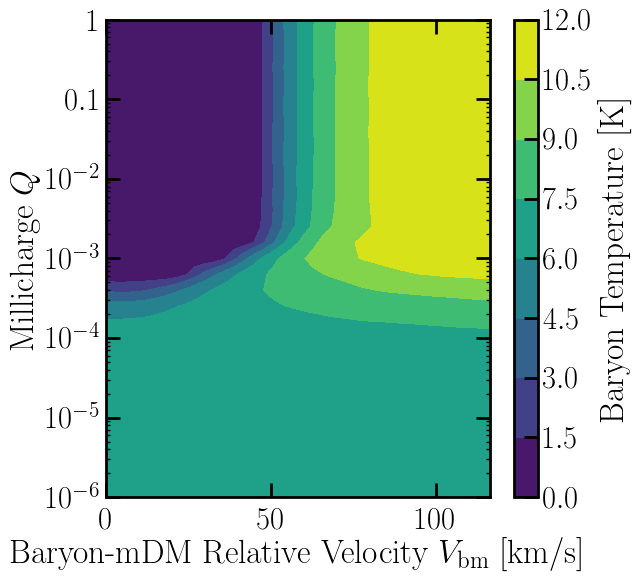

In [47]:
soln_arr, error_arr = pickle.load(open('/tigress/hongwanl/millicharged_DM_with_bath/data_Vrel_m_m_3e8.p','rb'))

# rs_vec[-9] is 1+z = 18. 

plt.figure()

plt.yscale('log')

plt.contourf(V_rel_arr * phys.c / 1e5, Q_arr,  soln_arr[:,:,-9,0] / phys.kB)

plt.colorbar(label='Baryon Temperature [K]')

plt.xlabel(r'Baryon-mDM Relative Velocity $V_\mathrm{bm}$ [km/s]')
plt.ylabel(r'Millicharge $Q$')


In [37]:
soln_arr.shape

(31, 40, 3990, 6)